### Dependencies & Prerequisites

In [1]:


from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [2]:
testnormal = tfd.Normal(loc=0,scale=1)


In [29]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

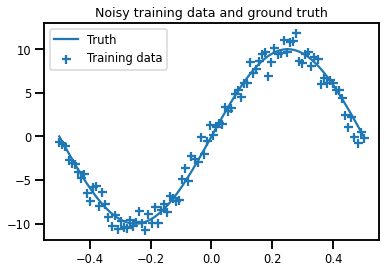

In [291]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 100
noise = 1.0

x= np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(x, sigma=noise)
y_true = f(x, sigma=0.0)

plt.scatter(x, y, marker='+', label='Training data')
plt.plot(x, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [292]:
# Test set for reference
x_tst = np.linspace(-1,1,100).reshape(-1,1)

In [293]:
# Why just the negative log likelihood?
negloglik = lambda y_true, rv_y: -rv_y.log_prob(y_true)

### Case 1: No Uncertainty

In [294]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(32,activation='relu',input_shape = (1,)),    
  tf.keras.layers.Dense(1,activation='linear'),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=0.1)),
],name='Sunny')

In [295]:
model.summary()

Model: "Sunny"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 33        
_________________________________________________________________
distribution_lambda_44 (Dist multiple                  0         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [296]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.03), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

In [297]:
# Output is still a distribution, but a useless one
yhat = model(x_tst)

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

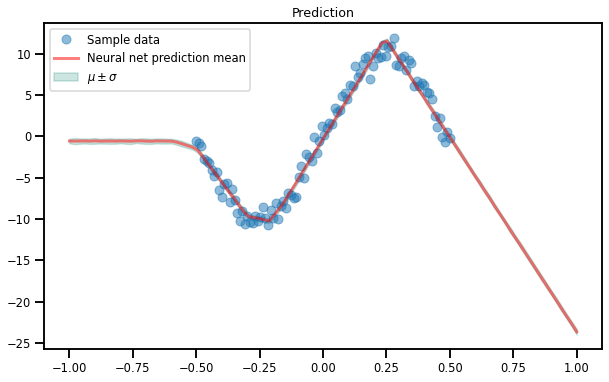

In [299]:
plt.figure(figsize=(10,6))
y_preds = yhat.sample(50).numpy().squeeze()
y_mean = y_preds.mean(axis=0)
y_sigma = y_preds.std(axis=0)

plt.plot(x, y,'o',label='Sample data',lw=2,alpha=0.5)
plt.plot(x_tst, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(x_tst.ravel(),
                 y_mean + 3*y_sigma,
                 y_mean - 3*y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm \sigma$')
plt.title('Prediction')
plt.legend();

### Case 2: Aleatoric Uncertainty

In [300]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10,activation='relu',input_shape=(1,)),
    tf.keras.layers.Dense(2), #It's two here because we also take into account the aleatoric error
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[:, :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[:,1:]))),
])

In [304]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=4000, verbose=False);

In [305]:
# Output is still a distribution, but a useless one
yhat = model(x_tst)

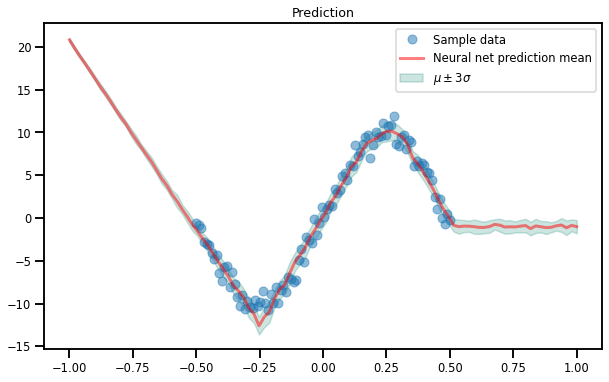

In [306]:
plt.figure(figsize=(10,6))
y_preds = yhat.sample(50).numpy().squeeze()
y_mean = y_preds.mean(axis=0)
y_sigma = y_preds.std(axis=0)

plt.plot(x, y,'o',label='Sample data',lw=2,alpha=0.5)
plt.plot(x_tst, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(x_tst.ravel(),
                 y_mean + y_sigma,
                 y_mean - y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm 3\sigma$')
plt.title('Prediction')
plt.legend();

### Case 3: Epistemic Uncertainty

In [310]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [311]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [319]:
# Build model.
model = tf.keras.Sequential([
  
  tfp.layers.DenseVariational(32,posterior_mean_field, prior_trainable, kl_weight=0.1, activation='relu',input_shape=(1,)),
  tfp.layers.DenseVariational(1,posterior_mean_field, prior_trainable,kl_weight = 0.1,activation='linear'),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

In [320]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_66 (DenseV (None, 32)                192       
_________________________________________________________________
dense_variational_67 (DenseV (None, 1)                 99        
_________________________________________________________________
distribution_lambda_47 (Dist multiple                  0         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [321]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=5000, verbose=False);

In [322]:
# Output is still a distribution, but a useless one
yhat = model(x_tst)

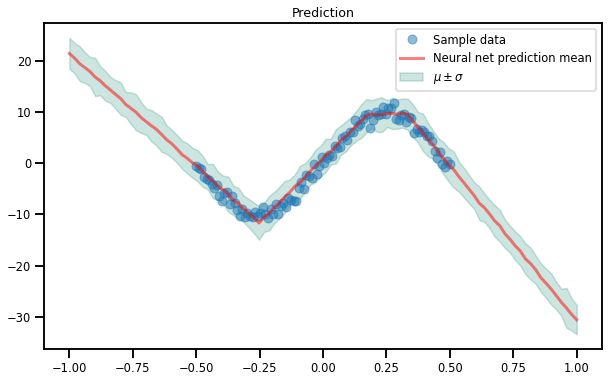

In [323]:
plt.figure(figsize=(10,6))
y_preds = yhat.sample(50).numpy().squeeze()
y_mean = y_preds.mean(axis=0)
y_sigma = y_preds.std(axis=0)

plt.plot(x, y,'o',label='Sample data',lw=2,alpha=0.5)
plt.plot(x_tst, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(x_tst.ravel(),
                 y_mean + 3*y_sigma,
                 y_mean - 3*y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm \sigma$')
plt.title('Prediction')
plt.legend();

In [346]:
# Build model.
model = tf.keras.Sequential([
  
  tfp.layers.DenseFlipout(20, activation='relu',input_shape=(1,)),
  tfp.layers.DenseFlipout(20, activation='relu',input_shape=(1,)),    
  tfp.layers.DenseFlipout(1),
    

In [350]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.fit(x, y, epochs=5000, verbose=False);

In [351]:
# Output is still a distribution, but a useless one
yhat = model(x_tst)

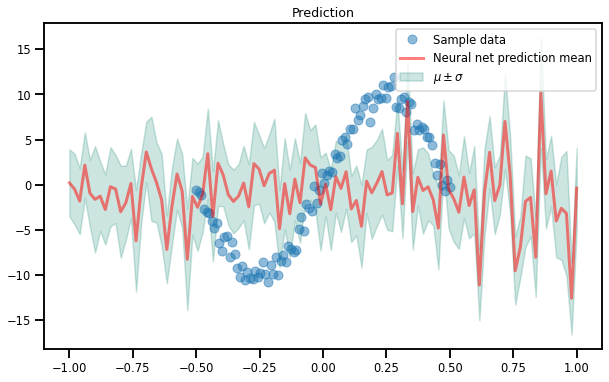

In [352]:
plt.figure(figsize=(10,6))
y_preds = yhat.sample(50).numpy().squeeze()
y_mean = y_preds.mean(axis=0)
y_sigma = y_preds.std(axis=0)

plt.plot(x, y,'o',label='Sample data',lw=2,alpha=0.5)
plt.plot(x_tst, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(x_tst.ravel(),
                 y_mean + 3*y_sigma,
                 y_mean - 3*y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm \sigma$')
plt.title('Prediction')
plt.legend();

### Case 4: Aleatoric & Epistemic Uncertainty

In [251]:
# Build model.
model = tf.keras.Sequential([
  
  tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/2,input_shape=(1,),activation='relu'),   
  tfp.layers.DenseVariational(2,posterior_mean_field, prior_trainable,kl_weight = 1/2,activation='linear'),
#   tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1))
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], scale=1e-3 + tf.math.softplus(0.01 * t[:,1:]))),
])

In [252]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.fit(x, y,batch_size=16,epochs=10000, verbose=False);

In [253]:
# Output is still a distribution, but a useless one
yhat = model(x_tst)

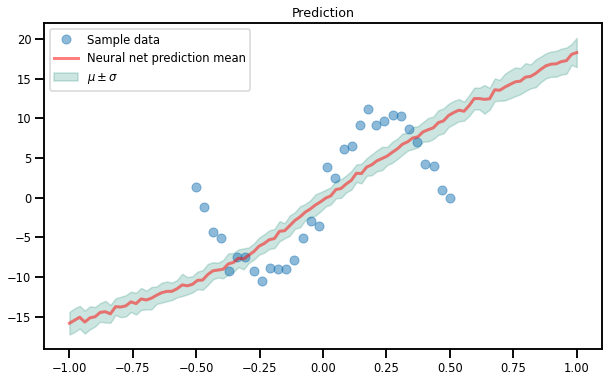

In [254]:
plt.figure(figsize=(10,6))
y_preds = yhat.sample(50).numpy().squeeze()
y_mean = y_preds.mean(axis=0)
y_sigma = y_preds.std(axis=0)

plt.plot(x, y,'o',label='Sample data',lw=2,alpha=0.5)
plt.plot(x_tst, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(x_tst.ravel(),
                 y_mean + y_sigma,
                 y_mean - y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm \sigma$')
plt.title('Prediction')
plt.legend();